# DAE Examples

In [72]:
from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator


Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q   = 100.0     # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
cA0 = 0.5       # Initial concentration [mol/L]
T0  = 350.0     # Initial temperature [K]
Tc  = 300.0     # Coolant temperature [K]


def cstr():
    
    m = ConcreteModel()
    m.t = ContinuousSet(bounds=(0.0, 10.0))
    m.cA = Var(m.t)
    m.T  = Var(m.t)
    m.dcA = DerivativeVar(m.cA)
    m.dT  = DerivativeVar(m.T)

    # Setting the initial conditions
    m.cA[0.0] = cA0
    m.T[0.0]  = T0
    
    k = lambda T: k0*exp(-Ea/R/T)
    m.ode1 = Constraint(m.t, rule=lambda m, t: 
        m.dcA[t] == (q/V)*(cAi - m.cA[t]) - k(m.T[t])*m.cA[t])
    m.ode2 = Constraint(m.t, rule=lambda m, t: 
        m.dT[t] == (q/V)*(Ti - m.T[t]) + (-dHr/rho/Cp)*k(m.T[t])*m.cA[t] + (UA/V/rho/Cp)*(Tc - m.T[t]))

    return m

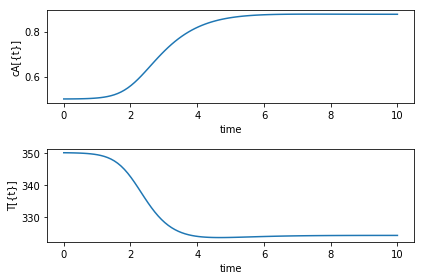

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

Tc = 300
sim = Simulator(cstr(), package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator='idas')

for idx,v in enumerate(sim.get_variable_order()):
    plt.subplot(2,1,idx+1)
    plt.plot(tsim,profiles[:,idx])
    plt.ylabel(v)
    plt.xlabel('time')

plt.tight_layout()